# Transferred DCNN (VGG16).

## Train datasets contain all users at 0 deg, Test datasets contain only 30, 45 and 60 deg. 
* Compare the effect of aspect angle on classification.


### Summary
*   Dataset 7 used 
*   3 second window
*   All movements
*   Cnn 64_128 model

Results to be compared with /baseline_model/train_all_0_30_45_60.ipynb

## Train or Load Toggle
This variable sets whether to load results or train the model.
* If set to True then the model will be trained, history saved, new graphs generated and saved and new analysis produced.
* If set to False then a pre-trained version of the model will be loaded along with a history object.

In [1]:
TRAIN_MODEL = True

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [31]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif os.getcwd() == 'D:\\Google Drive\\Level-4-Project\\notebooks\\baseline_models':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
else:
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/dataset_7/'
MODEL_PATH = BASE_PATH + 'models/baseline_model/train_all_0_test_30_45_60/'
RESULTS_PATH = BASE_PATH + 'results/baseline_model/train_all_0_test_30_45_60/'
REPORT_PATH = BASE_PATH + 'reports/baseline_model/train_all_0_test_30_45_60/'
    
from src.models.transferred_DCNN import vgg_16
from src.data import load_data
from src.visualization import multiple_plots, visualize_2, visualize

Import remaining packages

In [3]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
import pickle

In [4]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [5]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
batch_size = 100
nb_epoch = 20
nb_epoch = 1

# input image dimensions
img_rows, img_cols = 75, 75

In [6]:
datasets = {
    "train_data": DATA_PATH + "train_data.pkl",
    "train_labels": DATA_PATH + "train_labels.pkl",
    "test_data_30": DATA_PATH + "test_data_30.pkl",
    "test_labels_30": DATA_PATH + "test_labels_30.pkl",
    "test_data_45": DATA_PATH + "test_data_45.pkl",
    "test_labels_45": DATA_PATH + "test_labels_45.pkl",
    "test_data_60": DATA_PATH + "test_data_60.pkl",
    "test_labels_60": DATA_PATH + "test_labels_60.pkl"
}
loaded_data = load_data.load_data_specific_files(datasets)
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(loaded_data["train_labels"], nb_classes)
Y_test = np_utils.to_categorical(loaded_data["test_labels_60"], nb_classes)
X_train = loaded_data["train_data"].astype('float32')
X_test = loaded_data["test_data_60"].astype('float32')
X_train /= 255
X_test /= 255 
# Stack three times to fit VGG16 (RGB) treated as grayscale
x_train = np.hstack((x_train, x_train, x_train))
x_test = np.hstack((x_test, x_test, x_test))

In [7]:
results = {'30':{}, '45':{}, '60':{}}
for key, value in results.items():
    value["acc"] = None
    value["loss"] = None
    value["classification_report"] = None
    value["confusion_matrix"] = None

## Training and Evaluating Models

In [8]:
if TRAIN_MODEL:
    model = vgg_16.make_model(img_rows, img_cols, nb_classes)
    # train the model using SGD + momentum.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_data=(X_test, Y_test),
        shuffle=True, 
        verbose=1)
    model.save(MODELS_PATH + "model.h5")
    pickle.dump(history, open(RESULTS_PATH + "history.pkl", "wb"))
    
else:
    model = load_model(MODELS_PATH + "model.h5")
    history = pickle.load(open(RESULTS_PATH + "history.pkl", "rb"))

Train on 44951 samples, validate on 9104 samples
Epoch 1/1
44951/44951 [==============================] - 491s 11ms/step - loss: 0.5357 - acc: 0.8024 - val_loss: 2.9350 - val_acc: 0.4351


In [22]:
for angle, value in results.items(): 
    X_test = loaded_data["test_data_" + angle]
    y_test = loaded_data["test_labels_" +angle]
    y_test = np.reshape(y_test, (len(y_test), 1))
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)
    value["loss"] = evaluation[0]
    value["accuracy"] = evaluation[1]

    y_pred = model.predict_classes(X_test)
    value["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,target_names=target_names)
    value["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

[[6]
 [6]
 [6]
 ...
 [2]
 [2]
 [2]]
9104/9104 [==============================] - 27s 3ms/step
[[6]
 [6]
 [6]
 ...
 [2]
 [2]
 [2]]
6828/6828 [==============================] - 21s 3ms/step


C:\Users\macka\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[[6]
 [6]
 [6]
 ...
 [2]
 [2]
 [2]]
9104/9104 [==============================] - 27s 3ms/step


## Analysis and Saving of Results

In [34]:
save_graph = True

### Plot and Save graph

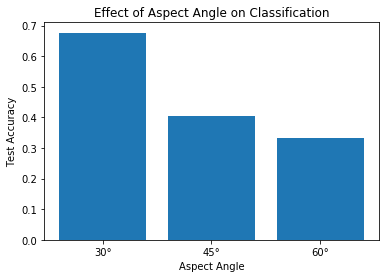

In [28]:
if not load_models:
    visualize.plot_evaluation_bar(
        results,
        ['30°', '45°', '60°'],
        "Effect of Aspect Angle on Classification",
        'Aspect Angle',
        'Test Accuracy',
        save=save_graph,
        path=REPORT_PATH + "aspect_angle_comparison.svg")

### Save Classification Report and Confusion Matricies

In [35]:
if save_report:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for folder_name, value in results.items():    
        file.write("--------------------------------------------------\n") 
        file.write("Test set name: " + folder_name + "\n") 
        file.write("Accuracy: " + str(np.round(value["accuracy"], 2)) + "\n")
        file.write("Loss: " + str(np.round(value["loss"], 2)) + "\n")
        file.write("Classification Report:\n") 
        file.write(value['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(value['confusion_matrix']) + "\n")

    file.close() 